
# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
---

<p style="text-align: center;">
<img src=http://www2.famaf.unc.edu.ar/~efernandez/egeo/img/logos/famaf.jpg width=40%>
</p>

 Universidad Nacional de Córdoba

---

## Practico: Aprendizaje No Supervisado

### Importación de librerías 

In [1]:
import pandas as pd 
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans,MeanShift,DBSCAN 
from sklearn import decomposition
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn import metrics
from tslearn.clustering import TimeSeriesKMeans

warnings.filterwarnings('ignore')

/Users/lucianomantovani/opt/miniconda3/envs/diplodatos-ayvd/lib/python3.6/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Lectura de los datasets

In [2]:
df_orig_mensual = pd.read_parquet("preprocesado_no_supervisado_agrupado.parquet")

In [3]:
df_orig_mensual = df_orig_mensual.copy()

In [4]:
df = df_orig_mensual.drop(columns = ['anio_mes_cupon', 'client_edad', 'client_domicilio_codigo_postal'])

In [5]:
df_orig_diario = pd.read_parquet("preprocesado_no_supervisado_diario.parquet")

In [6]:
df_orig_diario = df_orig_diario.copy()

In [7]:
df_diario = df_orig_diario.drop(columns = ['anio_mes_cupon', 'client_edad', 'client_domicilio_codigo_postal'])

### Normalización de Atributos y PCA

#### Escalado

In [8]:
# Preprocessing
features = df.columns
features_diario = df_diario.columns
dni = 'dni_titular_movimiento'
target = 'fg_aumentado'

features = features[(features != dni) & (features != target)]
features_diario = features_diario[(features_diario != dni)]

In [9]:
len(features)

42

In [10]:
scaler = StandardScaler()
df_escalado = pd.DataFrame(scaler.fit_transform(df[features]), columns=features)
df_escalado_diario = pd.DataFrame(scaler.fit_transform(df_diario[features_diario]), columns=features_diario)
df_escalado = pd.merge(df[[dni, target]], df_escalado, left_index=True, right_index=True)
df_escalado_diario = pd.merge(df_diario[[dni]], df_escalado_diario, left_index=True, right_index=True)

### Reducción de dimensionalidad dataset mensual

In [11]:
# Fit
pca = PCA (n_components=None)
pca_result = pca.fit_transform(df_escalado[features])

In [12]:
pca_result.shape

(10128, 42)

In [13]:
pca.explained_variance_ratio_.round(2)

array([0.17, 0.07, 0.05, 0.05, 0.04, 0.04, 0.04, 0.03, 0.03, 0.03, 0.03,
       0.03, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
       0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

<AxesSubplot:title={'center':'Porcentaje de la varianza total de los datos, \n explicada por cada componente principal \n'}>

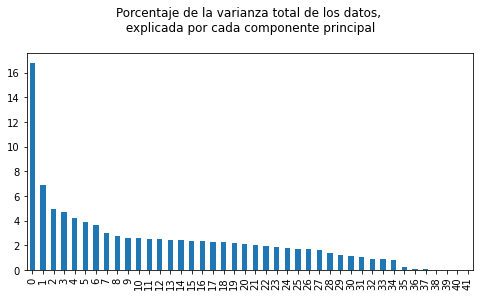

In [14]:
plt.figure(figsize=(8,4))
plt.title("Porcentaje de la varianza total de los datos, \n explicada por cada componente principal \n")
pd.Series(pca.explained_variance_ratio_.round(6)*100).plot(kind='bar')

In [15]:
acc_variance_percent = np.cumsum(np.round(pca.explained_variance_ratio_.round(2), decimals=4) * 100)
acc_variance_percent

array([ 17.,  24.,  29.,  34.,  38.,  42.,  46.,  49.,  52.,  55.,  58.,
        61.,  63.,  65.,  67.,  69.,  71.,  73.,  75.,  77.,  79.,  81.,
        83.,  85.,  87.,  89.,  91.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 100., 100., 100., 100., 100., 100., 100.])

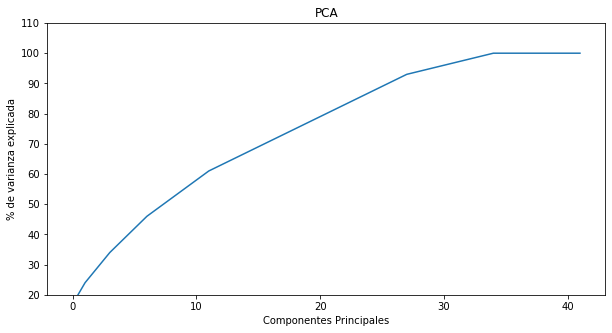

In [16]:
#plt.xticks(range(model['pca'].n_components))

plt.figure(figsize=(10, 5))
plt.ylabel('% de varianza explicada')
plt.xlabel('Componentes Principales')
plt.title('PCA')
plt.ylim(20, 110)
plt.xticks(pca.n_components)
plt.plot(acc_variance_percent)

In [17]:
pca_cols = [f'pca_{x}' for x in range(1,20)]
df_pca_final = pd.DataFrame(pca_result[:,:19], columns = pca_cols)
df_pca_final

pca_1     pca_2     pca_3     pca_4     pca_5     pca_6     pca_7  \
0     -2.172938 -0.308233  1.506251  0.197290 -0.118870 -0.085409 -0.336156   
1     -1.861384 -0.370582  1.394892  0.244533 -0.404208 -0.171829 -0.363350   
2     -1.877017 -0.375482  1.419741  0.241148 -0.392347 -0.172319 -0.355073   
3     -1.892649 -0.380383  1.444591  0.237763 -0.380486 -0.172810 -0.346796   
4     -1.908282 -0.385284  1.469440  0.234379 -0.368625 -0.173301 -0.338518   
...         ...       ...       ...       ...       ...       ...       ...   
10123  4.554080 -1.818086 -1.197495 -0.528243  1.180068  0.462852  1.692864   
10124  1.545434 -0.727974 -0.841720  0.284029 -1.907451 -0.367746  1.511578   
10125  0.592385 -0.372209 -0.522460  0.315424 -2.210050 -0.465656  1.645155   
10126 -0.858118 -0.220211 -0.324326 -0.120571 -0.247112  0.031925  2.661558   
10127 -2.407165  0.242100  0.717048 -0.055256  0.275782  0.244411  1.906773   

          pca_8     pca_9    pca_10    pca_11    pca_12    pca_13     pca_14  \
0     -0.002476  0.507725 -0.415513 -0.133621  0.151824 -0.575645  -0.501062   
1      0.076120  0.487026 -0.323531 -0.190155  0.070009 -0.466439  -0.463794   
2      0.096330  0.472174 -0.314812 -0.237062  0.021310 -0.358320  -0.474417   
3      0.116540  0.457323 -0.306094 -0.283968 -0.027390 -0.250201  -0.485039   
4      0.136750  0.442471 -0.297375 -0.330874 -0.076089 -0.142081  -0.495661   
...         ...       ...       ...       ...       ...       ...        ...   
10123 -1.280888 -0.268988 -1.563972 -0.476755  1.169929  0.301169  -0.114696   
10124 -0.490053 -0.755971 -0.280320  0.159807  0.381928  0.300278  -0.002874   
10125 -0.027132 -0.750016  0.463055  0.055032  0.101927  0.507197   0.224917   
10126  1.505922  0.689090 -0.869985  1.438139 -2.690005  6.500422  10.511854   
10127 -0.182034 -0.416611 -0.145394  0.091295  0.264965  0.704840  -0.249619   

          pca_15    pca_16    pca_17    pca_18    pca_19  
0       0.711840 -0.745799 -0.553676 -1.153545  0.399279  
1       0.633094 -0.657858 -0.466410 -0.971133  0.308996  
2       0.543499 -0.566162 -0.357077 -0.804571  0.245851  
3       0.453903 -0.474466 -0.247745 -0.638009  0.182707  
4       0.364308 -0.382770 -0.138412 -0.471447  0.119562  
...          ...       ...       ...       ...       ...  
10123  -0.492971  0.565743  1.942157 -0.638256 -0.430035  
10124  -0.201272  0.446719  0.767886 -0.143359 -0.710042  
10125  -0.143110  0.435463  0.257728  0.212326 -1.131044  
10126  13.241217 -0.501245  7.246561  0.994906  0.414336  
10127  -0.330083  0.540516  0.844665  0.298842 -0.783449  

[10128 rows x 19 columns]

In [18]:
df_pca = pd.merge(df[[dni, target]], df_pca_final, left_index=True, right_index=True)
df_pca

dni_titular_movimiento  fg_aumentado     pca_1     pca_2  \
0      000000b5aea2c9ea7cc155f6ebcef97f826             0 -2.172938 -0.308233   
1      000000b5aea2c9ea7cc155f6ebcef97f826             0 -1.861384 -0.370582   
2      000000b5aea2c9ea7cc155f6ebcef97f826             0 -1.877017 -0.375482   
3      000000b5aea2c9ea7cc155f6ebcef97f826             0 -1.892649 -0.380383   
4      000000b5aea2c9ea7cc155f6ebcef97f826             0 -1.908282 -0.385284   
...                                    ...           ...       ...       ...   
10123  000ef071e95351afc1149fa1afe4862a079             1  4.554080 -1.818086   
10124  000ef071e95351afc1149fa1afe4862a079             0  1.545434 -0.727974   
10125  000ef071e95351afc1149fa1afe4862a079             0  0.592385 -0.372209   
10126  000ef071e95351afc1149fa1afe4862a079             1 -0.858118 -0.220211   
10127  000ef071e95351afc1149fa1afe4862a079             0 -2.407165  0.242100   

          pca_3     pca_4     pca_5     pca_6     pca_7     pca_8  ...  \
0      1.506251  0.197290 -0.118870 -0.085409 -0.336156 -0.002476  ...   
1      1.394892  0.244533 -0.404208 -0.171829 -0.363350  0.076120  ...   
2      1.419741  0.241148 -0.392347 -0.172319 -0.355073  0.096330  ...   
3      1.444591  0.237763 -0.380486 -0.172810 -0.346796  0.116540  ...   
4      1.469440  0.234379 -0.368625 -0.173301 -0.338518  0.136750  ...   
...         ...       ...       ...       ...       ...       ...  ...   
10123 -1.197495 -0.528243  1.180068  0.462852  1.692864 -1.280888  ...   
10124 -0.841720  0.284029 -1.907451 -0.367746  1.511578 -0.490053  ...   
10125 -0.522460  0.315424 -2.210050 -0.465656  1.645155 -0.027132  ...   
10126 -0.324326 -0.120571 -0.247112  0.031925  2.661558  1.505922  ...   
10127  0.717048 -0.055256  0.275782  0.244411  1.906773 -0.182034  ...   

         pca_10    pca_11    pca_12    pca_13     pca_14     pca_15    pca_16  \
0     -0.415513 -0.133621  0.151824 -0.575645  -0.501062   0.711840 -0.745799   
1     -0.323531 -0.190155  0.070009 -0.466439  -0.463794   0.633094 -0.657858   
2     -0.314812 -0.237062  0.021310 -0.358320  -0.474417   0.543499 -0.566162   
3     -0.306094 -0.283968 -0.027390 -0.250201  -0.485039   0.453903 -0.474466   
4     -0.297375 -0.330874 -0.076089 -0.142081  -0.495661   0.364308 -0.382770   
...         ...       ...       ...       ...        ...        ...       ...   
10123 -1.563972 -0.476755  1.169929  0.301169  -0.114696  -0.492971  0.565743   
10124 -0.280320  0.159807  0.381928  0.300278  -0.002874  -0.201272  0.446719   
10125  0.463055  0.055032  0.101927  0.507197   0.224917  -0.143110  0.435463   
10126 -0.869985  1.438139 -2.690005  6.500422  10.511854  13.241217 -0.501245   
10127 -0.145394  0.091295  0.264965  0.704840  -0.249619  -0.330083  0.540516   

         pca_17    pca_18    pca_19  
0     -0.553676 -1.153545  0.399279  
1     -0.466410 -0.971133  0.308996  
2     -0.357077 -0.804571  0.245851  
3     -0.247745 -0.638009  0.182707  
4     -0.138412 -0.471447  0.119562  
...         ...       ...       ...  
10123  1.942157 -0.638256 -0.430035  
10124  0.767886 -0.143359 -0.710042  
10125  0.257728  0.212326 -1.131044  
10126  7.246561  0.994906  0.414336  
10127  0.844665  0.298842 -0.783449  

[10128 rows x 21 columns]

### Visualización mediante t-distributed Stochastic Neighbor Embedding

Visualizar los datos usando t-distributed Stochastic Neighbor Embedding.
* Se pueden sacar conclusiones del grafico?



#### Sobre el dataset agrupado mensual

In [19]:
df_tsne = df_escalado.drop(columns = [dni]) 

Instanciamos TSNE con los parametros que regularmente se usan

In [20]:
tsne = TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000, init='random', random_state = 15) 

In [21]:
X_tsne_all = tsne.fit_transform(df_tsne)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10128 samples in 0.001s...
[t-SNE] Computed neighbors for 10128 samples in 6.354s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10128
[t-SNE] Computed conditional probabilities for sample 2000 / 10128
[t-SNE] Computed conditional probabilities for sample 3000 / 10128
[t-SNE] Computed conditional probabilities for sample 4000 / 10128
[t-SNE] Computed conditional probabilities for sample 5000 / 10128
[t-SNE] Computed conditional probabilities for sample 6000 / 10128
[t-SNE] Computed conditional probabilities for sample 7000 / 10128
[t-SNE] Computed conditional probabilities for sample 8000 / 10128
[t-SNE] Computed conditional probabilities for sample 9000 / 10128
[t-SNE] Computed conditional probabilities for sample 10000 / 10128
[t-SNE] Computed conditional probabilities for sample 10128 / 10128
[t-SNE] Mean sigma: 1.149792
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.250031
[t-SNE] KL 

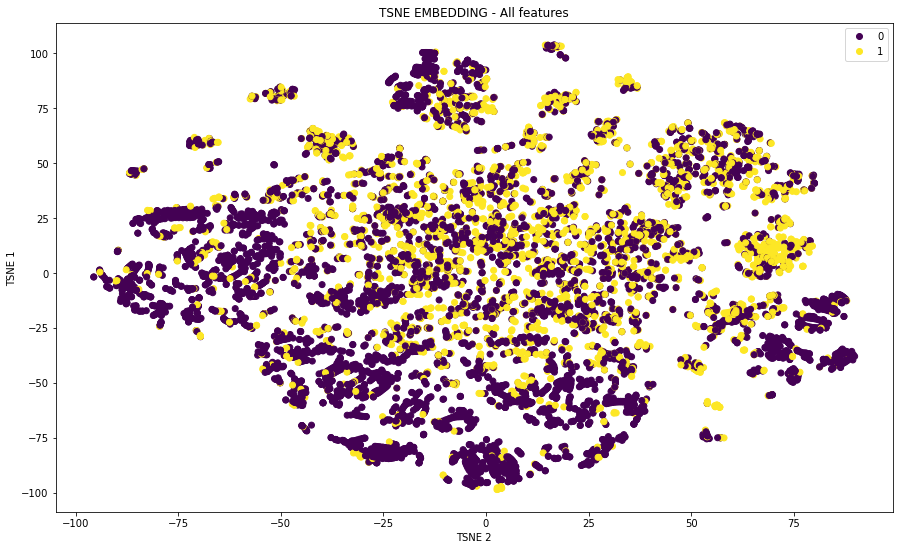

In [22]:
# Plot de resultado en 2 dimensiones
plt.figure(figsize=(15, 9))
plt.ylabel('TSNE 1')
plt.xlabel('TSNE 2')
plt.title('TSNE EMBEDDING - All features')
scatter = plt.scatter(X_tsne_all[:,0], X_tsne_all[:,1], c=df['fg_aumentado'])
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, df['fg_aumentado'].unique())

El grafico anterior muestra todas las transacciones del dataset reducidas a dos dimensiones para poder visualizarlas. En principio habria ciertos grupos identificables. Sin tener en cuenta la etiqueta elegida, podemos observar ciertos conglomerados de puntos de distinta densidad, con forma de blob. 
Si tenemos en cuenta la etiqueta, a pesar de que ningún grupo tiene la completitud de una de las clases, si se pueden observan algunos con mayoría de puntos violetas o mayoría de amarillos. Aquellos conglomerados más amplios, tiene en su mayoría puntos de color de violetas, mientras que los más pequeños parecen tener mayoría de puntos amarillos.  

#### Sobre el dataset diario

In [93]:
df_tsne_diario = df_escalado_diario.drop(columns = [dni]) 

Instanciamos TSNE con los parametros que regularmente se usan

In [94]:
tsne = TSNE(n_components=2, verbose=1,perplexity=30, n_iter=1000, init='random', random_state = 15) 

In [95]:
X_tsne_diario = tsne.fit_transform(df_tsne_diario)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 65383 samples in 0.006s...
[t-SNE] Computed neighbors for 65383 samples in 160.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 65383
[t-SNE] Computed conditional probabilities for sample 2000 / 65383
[t-SNE] Computed conditional probabilities for sample 3000 / 65383
[t-SNE] Computed conditional probabilities for sample 4000 / 65383
[t-SNE] Computed conditional probabilities for sample 5000 / 65383
[t-SNE] Computed conditional probabilities for sample 6000 / 65383
[t-SNE] Computed conditional probabilities for sample 7000 / 65383
[t-SNE] Computed conditional probabilities for sample 8000 / 65383
[t-SNE] Computed conditional probabilities for sample 9000 / 65383
[t-SNE] Computed conditional probabilities for sample 10000 / 65383
[t-SNE] Computed conditional probabilities for sample 11000 / 65383
[t-SNE] Computed conditional probabilities for sample 12000 / 65383
[t-SNE] Computed conditional probabilities for s

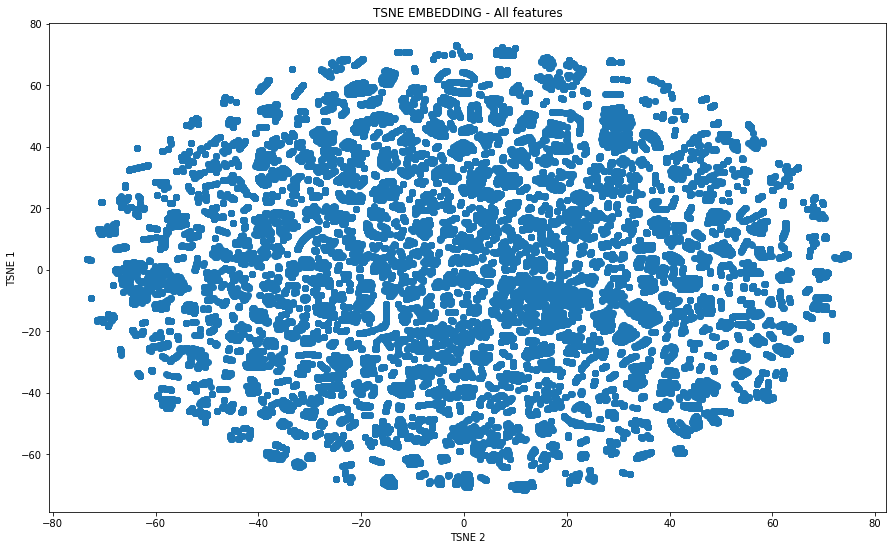

In [96]:
# Plot de resultado en 2 dimensiones
plt.figure(figsize=(15, 9))
plt.ylabel('TSNE 1')
plt.xlabel('TSNE 2')
plt.title('TSNE EMBEDDING - All features')
scatter = plt.scatter(X_tsne_diario[:,0], X_tsne_diario[:,1])
handles, _ = scatter.legend_elements(prop='colors')

### K-Means Clustering

K-Means Clustering
Explorar distintas soluciones de clustering con diferentes parámetros,
como iteraciones, número de clusters o métricas de distancia, y compararlas. 
Finalmente, para el modelo seleccionado:
> Aplicar K-Means tanto al dataset original como al dataset transformado.

* Calcular las métricas pertinentes sobre los clusters resultantes.
* Aplicando el método de Elbow, ¿cuál sería la cantidad óptima de clusters?
* Agregar al dataset el cluster resultante de los modelos.
* Graficar diferentes variables de interés por cluster y compararlos.

#### SOBRE DF CON PCA (TRANSFORMADO) 

Para n_clusters = 4 El silhouette_score promedio es : 0.23859603279841887
Para n_clusters = 6 El silhouette_score promedio es : 0.1721799924234391
Para n_clusters = 8 El silhouette_score promedio es : 0.1684679439673782
Para n_clusters = 10 El silhouette_score promedio es : 0.17274778973713675
Para n_clusters = 12 El silhouette_score promedio es : 0.182660194275089
Para n_clusters = 14 El silhouette_score promedio es : 0.10942691769768517
Para n_clusters = 16 El silhouette_score promedio es : 0.11705517403019353


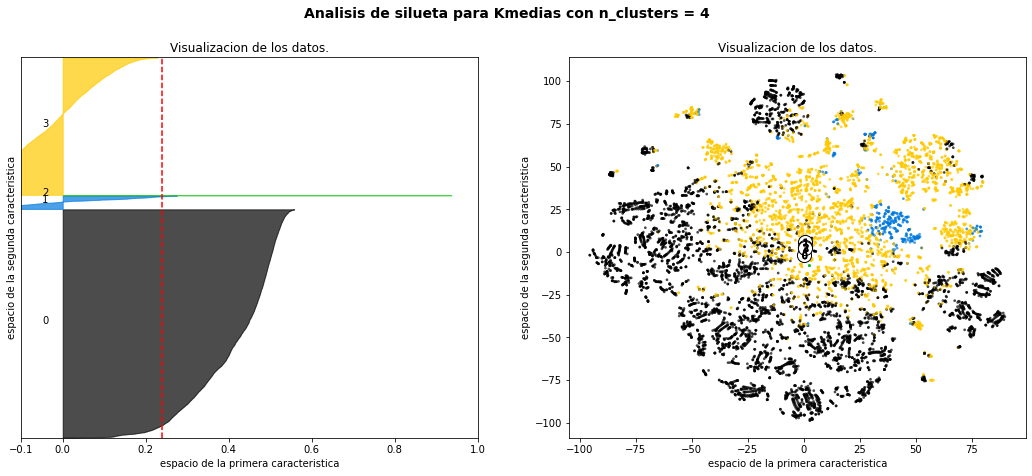

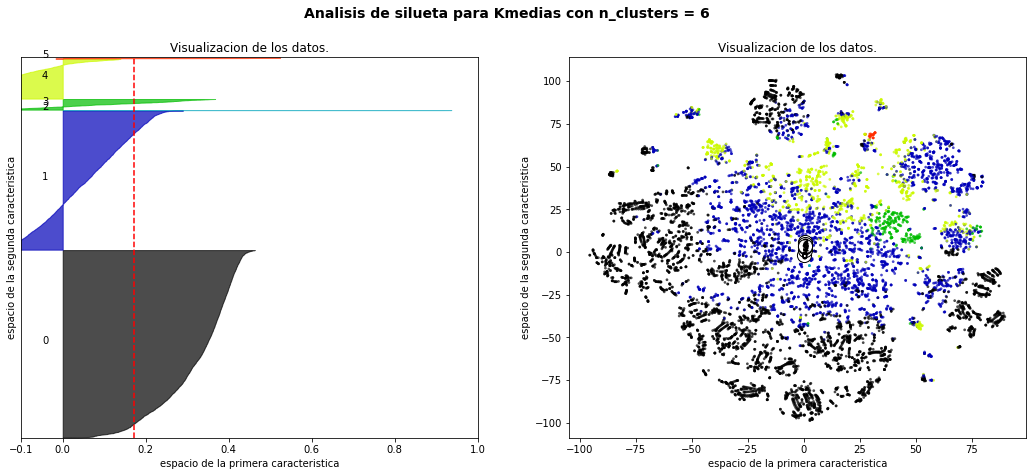

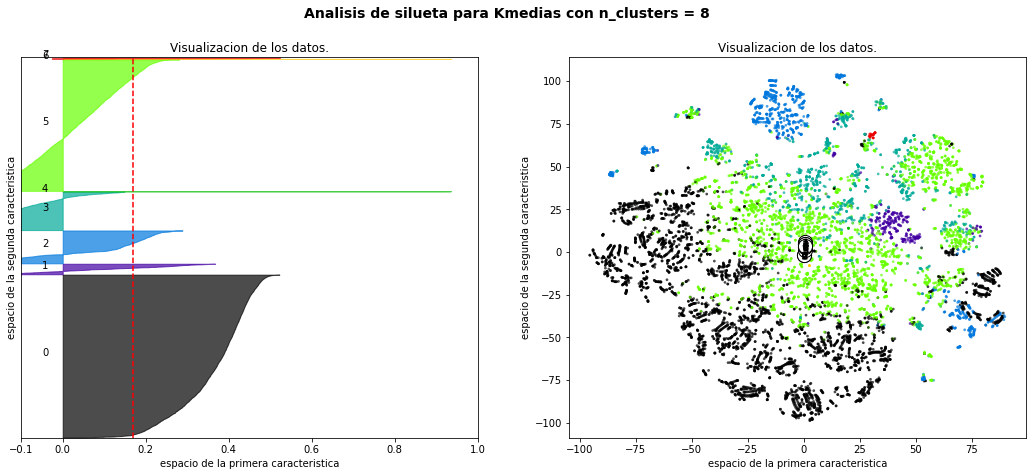

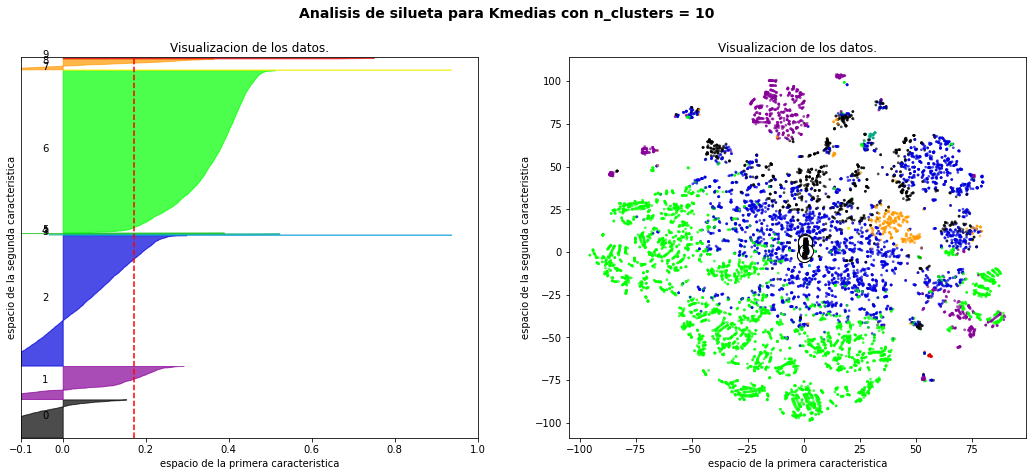

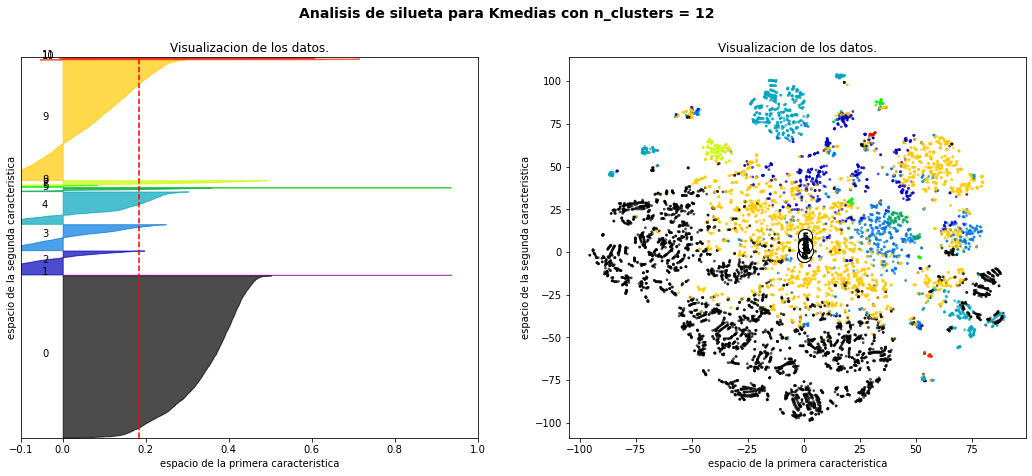

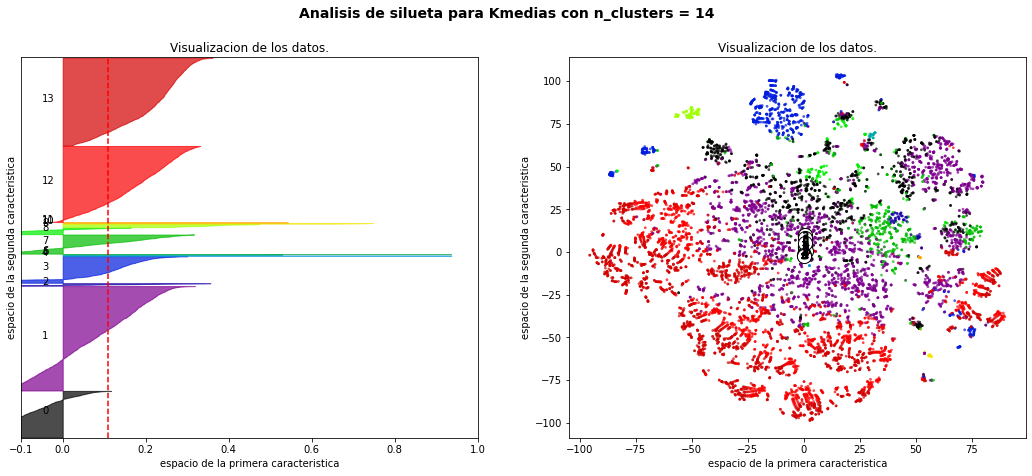

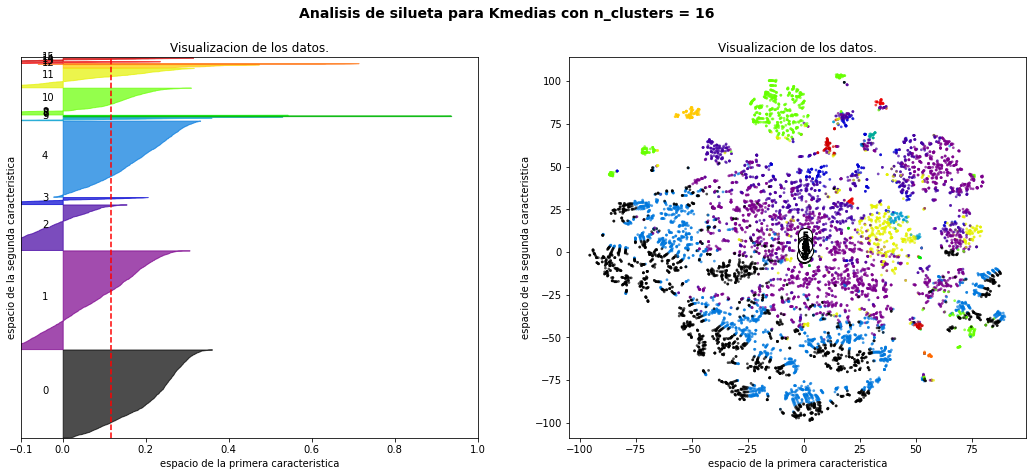

In [97]:
# con DF- PCA
X = df_pca.drop(columns = [dni])

range_n_clusters = [4,6,8,10,12,14,16]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 100 )
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_tsne_all[:, 0], X_tsne_all[:, 1]
                , marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

EN ESTA PARTE VOLVER A INSTANCIAR EL MEJOR MODELO 

Text(0.5, 1.0, 'Inertia of k-Means versus number of clusters')

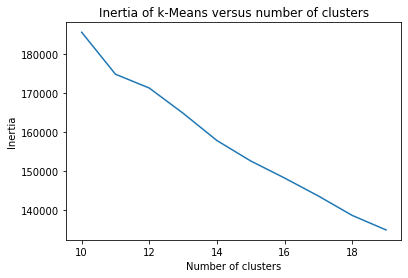

In [98]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 10 a 20 
scores = [KMeans(n_clusters=i, random_state = 28).fit(df_pca.drop(columns = [dni])).inertia_ for i in range(10,20)]

plt.plot(np.arange(10, 20), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [99]:
# Número de clusters buscado
n_clust = 15

km = KMeans(n_clusters=n_clust)
km.fit(df_pca.drop(columns = [dni])) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster(Inertia) ', km.inertia_)

Suma de los cuadrados de las distancias al cluster(Inertia)  153189.73763638202


In [100]:
X = df_pca.drop(columns = [dni])
print('Coeficiente de silueta =', silhouette_score(X, clusters))

Coeficiente de silueta = 0.10980205127458238


In [101]:
df_clusters=df.copy()
df_clusters['cluster_kmeans'] = km.labels_ #clusters
df_clusters.cluster_kmeans.value_counts()

1     2304
6     2141
14    1933
0     1628
11     712
5      661
2      419
4      121
9       87
13      51
7       31
12      19
10      15
3        3
8        3
Name: cluster_kmeans, dtype: int64

In [102]:
pd.options.display.max_columns = None
df_clusters.groupby(by=['cluster_kmeans','fg_aumentado']).size()

cluster_kmeans  fg_aumentado
0               0                892
                1                736
1               0               2079
                1                225
2               0                174
                1                245
3               0                  2
                1                  1
4               0                 39
                1                 82
5               0                235
                1                426
6               0               1896
                1                245
7               0                 10
                1                 21
8               0                  1
                1                  2
9               0                 49
                1                 38
10              0                  5
                1                 10
11              0                566
                1                146
12              1                 19
13              0                 24
         

NameError: name 'X_tsne_all_redux' is not defined

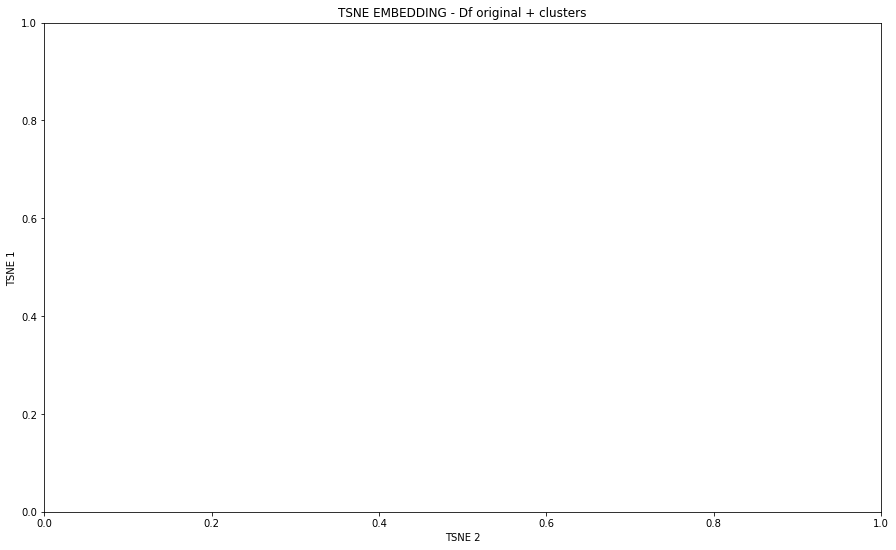

In [103]:
# Plot de resultado en 2 dimensiones
plt.figure(figsize=(15, 9))
plt.ylabel('TSNE 1')
plt.xlabel('TSNE 2')
plt.title('TSNE EMBEDDING - Df original + clusters')
scatter = plt.scatter(X_tsne_all_redux[:,0], X_tsne_all_redux[:,1], c=df_clusters['cluster_kmeans'])
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, df_clusters['cluster_kmeans'].unique())

#### SOBRE DF ORIGINAL ESCALADO (SIN PCA)

Para n_clusters = 6 El silhouette_score promedio es : 0.12449761461820642
Para n_clusters = 8 El silhouette_score promedio es : 0.1315130101957449
Para n_clusters = 10 El silhouette_score promedio es : 0.11280404601874695
Para n_clusters = 12 El silhouette_score promedio es : 0.05601483537921516
Para n_clusters = 14 El silhouette_score promedio es : 0.04762506346658778
Para n_clusters = 16 El silhouette_score promedio es : 0.0702466211439251


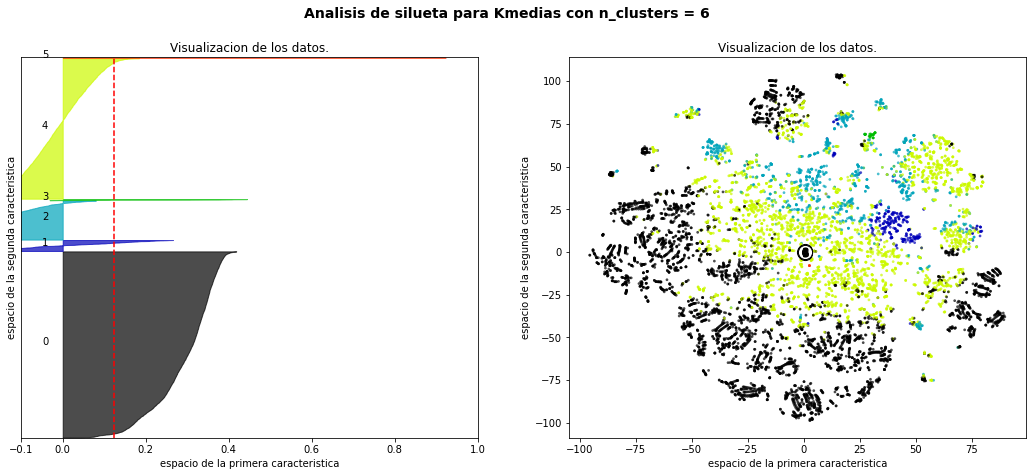

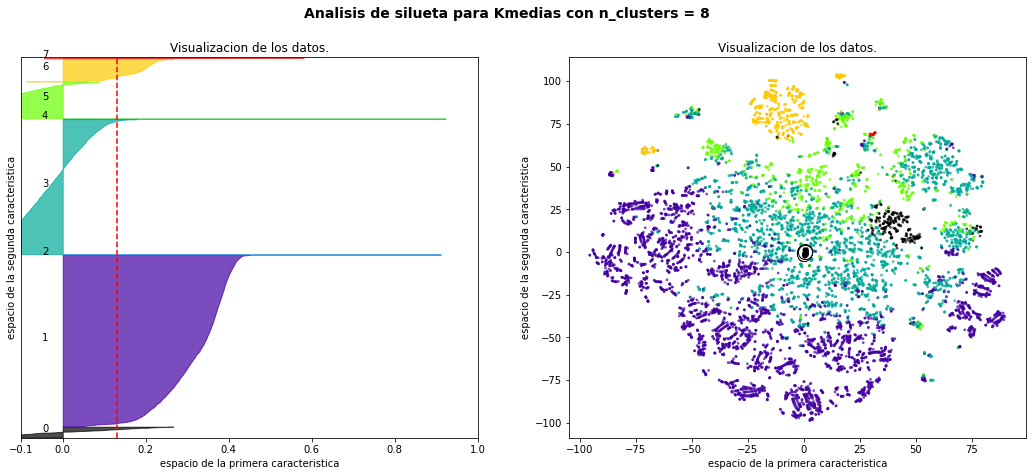

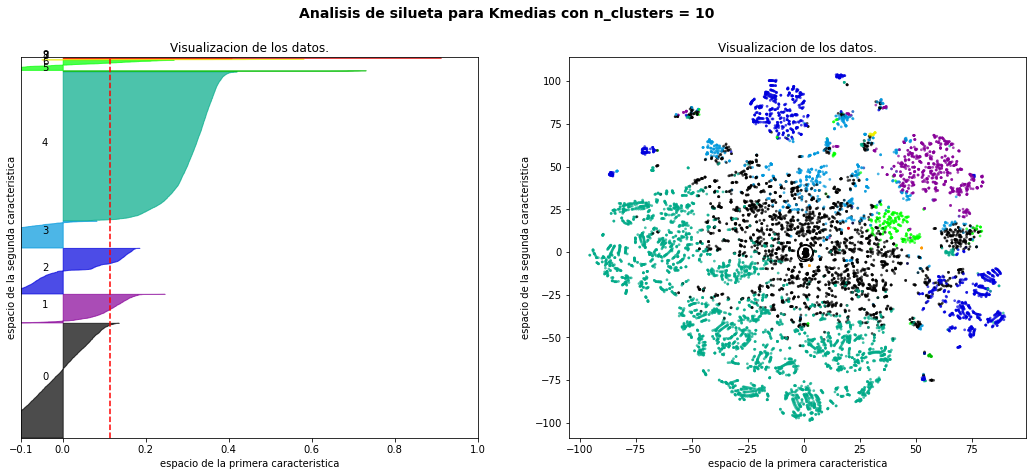

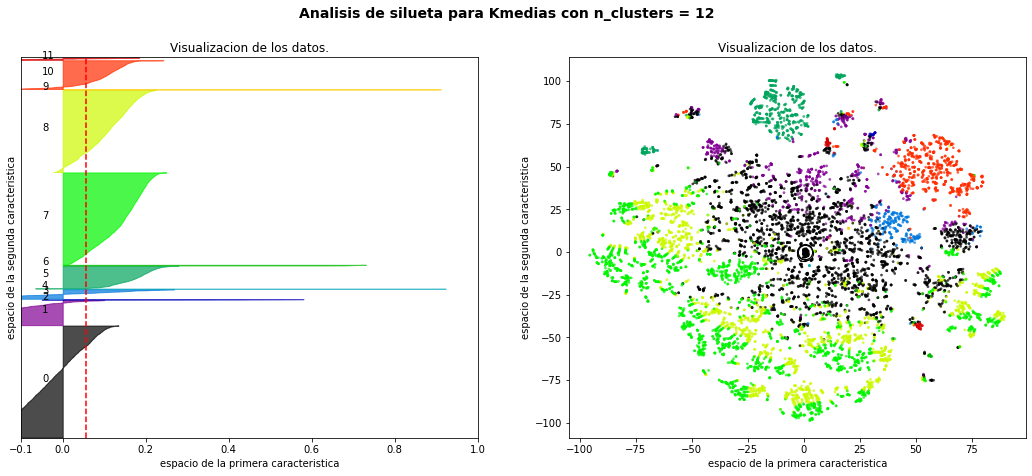

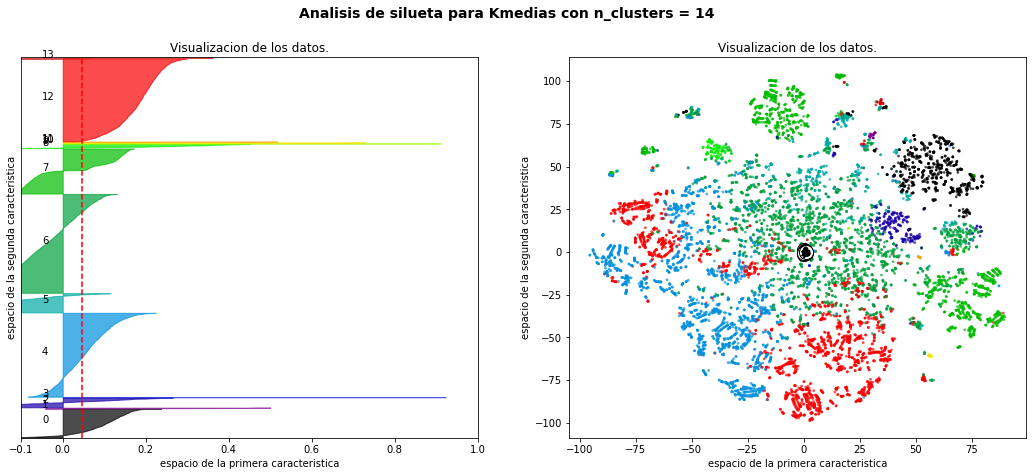

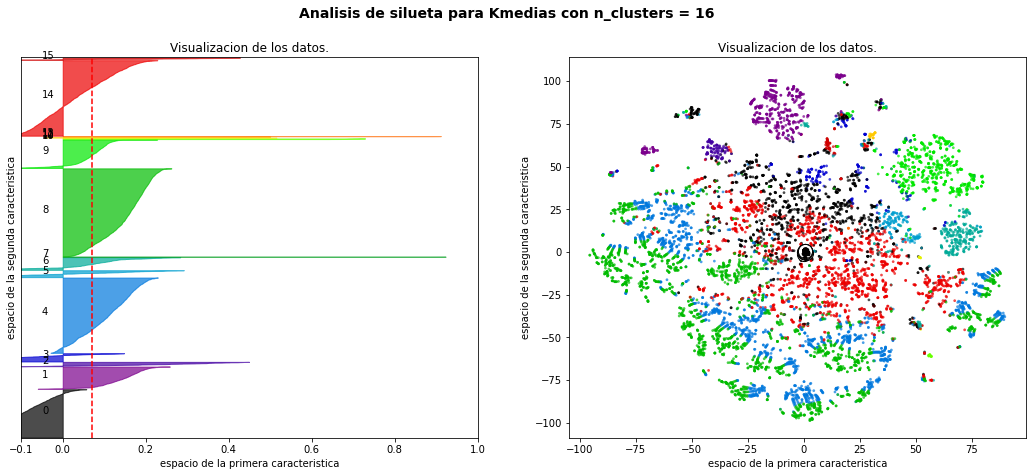

In [104]:
# con DF sin PCA
X = df_escalado.drop(columns=[dni])

range_n_clusters = [6,8,10,12,14,16]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 100 )
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_tsne_all[:, 0], X_tsne_all[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

EN ESTA PARTE VOLVER A INSTANCIAR EL MEJOR MODELO

In [105]:
# Número de clusters buscado
n_clust = 4

km = KMeans(n_clusters=n_clust, n_init = 100)
km.fit(df_escalado) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster(Inertia) ', km.inertia_)

ValueError: could not convert string to float: '000000b5aea2c9ea7cc155f6ebcef97f826'

In [106]:
print('Coeficiente de silueta =', silhouette_score(df_escalado, clusters))

ValueError: could not convert string to float: '000000b5aea2c9ea7cc155f6ebcef97f826'

In [107]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, random_state = 28).fit(df_escalado).inertia_ for i in range(10,20)]

plt.plot(np.arange(10, 20), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

ValueError: could not convert string to float: '000000b5aea2c9ea7cc155f6ebcef97f826'

In [108]:
df_clusters=df.copy()
df_clusters['cluster_kmeans'] = km.labels_ #clusters
df_clusters.cluster_kmeans.value_counts()

AttributeError: 'KMeans' object has no attribute 'labels_'

In [109]:
pd.options.display.max_columns = None
df_clusters.groupby(by=['cluster_kmeans','fg_aumentado']).size()

KeyError: 'cluster_kmeans'

In [110]:
plt.figure(figsize=(20,15))
cluster = df_clusters['cluster_kmeans'].astype(str)
# = df_clusters['cluster_kmeans'].astype(str)
sns.boxenplot(data=df_clusters, x='monto_ajustado', y=cluster, hue='mean_est_civil')

KeyError: 'cluster_kmeans'

<Figure size 1440x1080 with 0 Axes>

In [111]:
sns.scatterplot(data=df, x='monto_ajustado', y='client_antig', hue=cluster)

NameError: name 'cluster' is not defined

KeyError: 'cluster_kmeans'

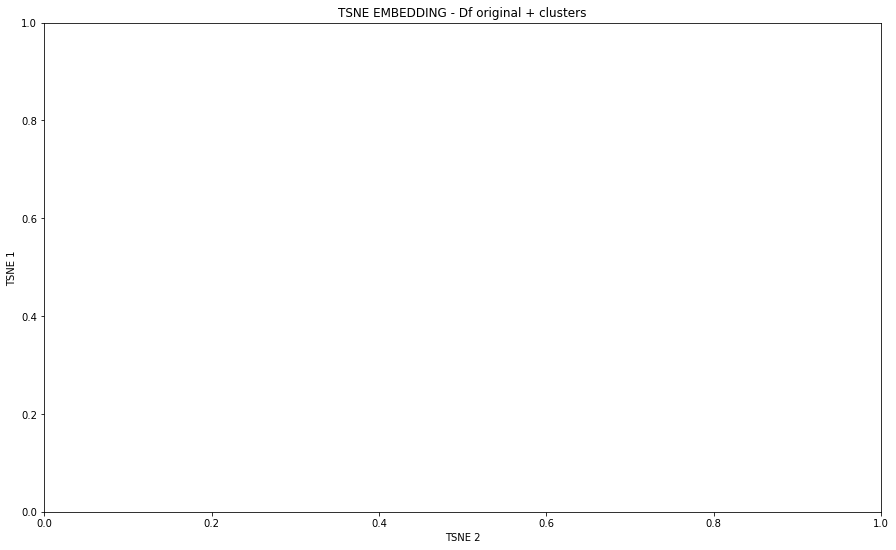

In [112]:
# Plot de resultado en 2 dimensiones
plt.figure(figsize=(15, 9))
plt.ylabel('TSNE 1')
plt.xlabel('TSNE 2')
plt.title('TSNE EMBEDDING - Df original + clusters')
scatter = plt.scatter(X_tsne_all[:,0], X_tsne_all[:,1], c=df_clusters['cluster_kmeans'])
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, df_clusters['cluster_kmeans'].unique())

#### SOBRE DF ORIGINAL DIARIO ESCALADO (SIN PCA)

In [ ]:
# con DF sin PCA
X = df_escalado_diario.drop(columns=[dni])

range_n_clusters = [4,6,8,10,12,14,16]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10, n_init = 100 )
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X_tsne_diario[:, 0], X_tsne_diario[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

Para n_clusters = 4 El silhouette_score promedio es : 0.1808080405567441


KeyboardInterrupt: 

#### SOBRE EL DF TSNE

In [ ]:
X = X_tsne_all

range_n_clusters = [6,8,10,12,14,16]
sse ={}
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    sse[n_clusters] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("Para n_clusters =", n_clusters,
          "El silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")

    plt.suptitle(("Analisis de silueta para Kmedias "
                  "con n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)

plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
plt.suptitle(("Metodo del codo para kmedias "),
                 fontsize=14, fontweight='bold')
ax1.plot(list(sse.keys()), list(sse.values()))
ax1.set_xlabel("Numero of cluster")
ax1.set_ylabel("Inercia")

clusterer = KMeans(n_clusters=4, random_state=10)
cluster_labels = clusterer.fit_predict(X)
    
colors = cm.nipy_spectral(cluster_labels.astype(float) / 4)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,c=colors, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,s=50, edgecolor='k')

ax2.set_title("Visualizacion de los datos.")
ax2.set_xlabel("espacio de la primera caracteristica")
ax2.set_ylabel("espacio de la segunda caracteristica")

#plt.savefig("kmeans_elbow", dpi=300)
plt.show()

In [ ]:
# Número de clusters buscado
n_clust = 6

km = KMeans(n_clusters=n_clust)
km.fit(X_tsne_all) 

# Recuperacion de etiquetas
clusters = km.labels_
print('Suma de los cuadrados de las distancias al cluster(Inertia) ', km.inertia_)

In [ ]:
X = X_tsne_all
print('Coeficiente de silueta =', silhouette_score(X, clusters))

In [ ]:
#Prueba: para elegir el hiperparámetro n_clusters, variando de 2 a 11 clusters
scores = [KMeans(n_clusters=i, random_state = 28).fit(X_tsne_all).inertia_ for i in range(10,20)]

plt.plot(np.arange(10, 20), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

In [ ]:
df_clusters=df.copy()
df_clusters['cluster_kmeans'] = km.labels_ #clusters
df_clusters.cluster_kmeans.value_counts()

In [ ]:
pd.options.display.max_columns = None
df_clusters.groupby(by=['cluster_kmeans','fg_aumentado']).size()

In [ ]:
plt.figure(figsize=(20,15))
cluster = df_clusters['cluster_kmeans'].astype(str)
# = df_clusters['cluster_kmeans'].astype(str)
sns.boxenplot(data=df_clusters, x='monto_ajustado', y=cluster, hue='mean_est_civil')

In [ ]:
sns.scatterplot(data=df, x='monto_ajustado', y='client_antig', hue=cluster)

### HDBScan Clustering

HDBScan Clustering.
Este algoritmo es de clusterización apropiado para detectar anomalias (outliers).
* comparar los clusters con los del punto anterior usando silhouette Analisys

In [ ]:
dbscan = DBSCAN(eps=0.8, min_samples = 10)
dbscan.fit(X_tsne_all)

clusters = dbscan.labels_

In [ ]:
print('Coeficiente de silueta =', silhouette_score(X_tsne_all, clusters))

In [ ]:
df_clusters_2=df.copy()
df_clusters_2['cluster_dbscan'] = dbscan.labels_ #clusters
df_clusters_2.cluster_dbscan.value_counts()

In [ ]:
plt.figure(figsize=(20,15))
cluster = df_clusters_2['cluster_dbscan'].astype(str)
# = df_clusters['cluster_kmeans'].astype(str)
sns.boxenplot(data=df_clusters_2, x='monto_ajustado', y=cluster, hue='mean_sexo')

In [ ]:
labels_true = df['fg_aumentado']

In [ ]:
db = DBSCAN(eps=1.5, min_samples=10).fit(X_tsne_all)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_escalado, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_tsne_all[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_tsne_all[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()
# #############################################################################
# Compute DBSCAN

#EPS = 0.7 
db = DBSCAN(eps=0.5, min_samples=10).fit(X_tsne_all)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_escalado, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_tsne_all[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_tsne_all[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

# #############################################################################
# Compute DBSCAN

#EPS = 0.8 
db = DBSCAN(eps=0.7, min_samples=10).fit(X_tsne_all)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels,
                                           average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_escalado, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.autumn(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X_tsne_all[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X_tsne_all[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [ ]:
# Plot de resultado en 2 dimensiones
plt.figure(figsize=(15, 9))
plt.ylabel('TSNE 1')
plt.xlabel('TSNE 2')
plt.title('TSNE EMBEDDING - Df original + clusters')
scatter = plt.scatter(X_tsne_all[:,0], X_tsne_all[:,1], c=df_clusters_2['cluster_dbscan'])
handles, _ = scatter.legend_elements(prop='colors')
plt.legend(handles, df_clusters_2['cluster_dbscan'].unique())

### K-Means Clustering para Series Temporales

La idea es segmentar a los clientes en base a sus series temporales
usando el monto y la fecha del monto de movimiento.
* Usar la libreria [ts-learn](https://tslearn.readthedocs.io/en/stable/auto_examples/clustering/plot_kmeans.html) 


> Agregar al dataset el cluster resultante de los modelos.

La serie temporal se escala usando TimeSeriesScalerMeanVariance. Este scaler provoca que la salida de cada serie temporal tenga media 0 y varianza unitaria. Aqui asumimos que el rango de la serie temporal no aporta informacion y solo queremos comparar las distintas formas independientemente de la variacion de amplitud entre ellas.

In [23]:
df = pd.read_parquet('cupones_no_supervisado.parquet')

Eliminamos outliers y duplicados tal como se hace en el practico 2

In [24]:
df = df[df['fecha_cupon_movimiento'] > pd.to_datetime('2020-07-01')]
df = df[(df['monto_ajustado'] > -63712) & (df['monto_ajustado'] < 63712)]
df = df[~df.duplicated()]

Para armar los clusters de series temporales solo necesitamos los dnis de los clientes, las fechas, y los montos.

In [25]:
fecha = 'fecha_cupon_movimiento'
dni = 'dni_titular_movimiento'
monto = 'monto_ajustado'

In [26]:
df[[fecha, dni, monto]].copy()

fecha_cupon_movimiento               dni_titular_movimiento  \
0                  2020-08-25  0001686b52949b5461ffcbc766687e45031   
1                  2020-08-25  000220fa96ec5af89817894033f8099c547   
2                  2020-08-25  0002be202de47dfae9cc2304d91161be595   
3                  2020-08-25  000e137d0af42e193be1ff670c00d4d1506   
4                  2020-08-25  0009d010e4faf69552a814a33832b185877   
...                       ...                                  ...   
124306             2021-05-14  0002716f6d9c2130a8c88a0219de234d459   
124309             2021-05-14  0001f61dd2845a7e653ebfdaf22dab3b373   
124311             2021-05-14  0006c15ca823454b68c189da1344d9d7317   
124312             2021-05-03  0000ab27a0ed815f947df8bcb834ff97975   
124313             2021-05-03  0000ab27a0ed815f947df8bcb834ff97975   

        monto_ajustado  
0                 5.52  
1                15.68  
2                 5.46  
3                 2.50  
4                 2.10  
...                ...  
124306         9661.01  
124309        20329.24  
124311        13210.67  
124312          121.73  
124313        12284.16  

[65349 rows x 3 columns]

Armamos un nuevo dataframe de forma que haya una serie temporal por cada dni, con la suma de sus compras en cada fecha.

In [27]:
dfs = pd.pivot_table(df[[fecha, dni, monto]], values=monto, index=fecha, columns=dni, aggfunc=np.sum, fill_value=0)
dfs

dni_titular_movimiento  000000b5aea2c9ea7cc155f6ebcef97f826  \
fecha_cupon_movimiento                                        
2020-07-03                                              0.0   
2020-07-04                                              0.0   
2020-07-05                                              0.0   
2020-07-06                                              0.0   
2020-07-07                                              0.0   
...                                                     ...   
2021-05-21                                              0.0   
2021-05-22                                              0.0   
2021-05-23                                              0.0   
2021-05-24                                              0.0   
2021-05-25                                              0.0   

dni_titular_movimiento  00000b8415f19846d12e852ebd0d52ec432  \
fecha_cupon_movimiento                                        
2020-07-03                                              0.0   
2020-07-04                                              0.0   
2020-07-05                                              0.0   
2020-07-06                                              0.0   
2020-07-07                                              0.0   
...                                                     ...   
2021-05-21                                              0.0   
2021-05-22                                              0.0   
2021-05-23                                              0.0   
2021-05-24                                              0.0   
2021-05-25                                              0.0   

dni_titular_movimiento  00000d109ca5a0c6b3e76295f0292c38189  \
fecha_cupon_movimiento                                        
2020-07-03                                              0.0   
2020-07-04                                              0.0   
2020-07-05                                              0.0   
2020-07-06                                              0.0   
2020-07-07                                              0.0   
...                                                     ...   
2021-05-21                                              0.0   
2021-05-22                                              0.0   
2021-05-23                                              0.0   
2021-05-24                                              0.0   
2021-05-25                                              0.0   

dni_titular_movimiento  000017309738c042c2ec144d5d3d3632673  \
fecha_cupon_movimiento                                        
2020-07-03                                              0.0   
2020-07-04                                              0.0   
2020-07-05                                              0.0   
2020-07-06                                              0.0   
2020-07-07                                              0.0   
...                                                     ...   
2021-05-21                                              0.0   
2021-05-22                                              0.0   
2021-05-23                                              0.0   
2021-05-24                                              0.0   
2021-05-25                                              0.0   

dni_titular_movimiento  00001b02afa8956b08af05c339039882046  \
fecha_cupon_movimiento                                        
2020-07-03                                              0.0   
2020-07-04                                              0.0   
2020-07-05                                              0.0   
2020-07-06                                              0.0   
2020-07-07                                              0.0   
...                                                     ...   
2021-05-21                                              0.0   
2021-05-22                                              0.0   
2021-05-23                                              0.0   
2021-05-24                 

El dataset (curado) comprende 319 dias donde 844 clientes distintos realizaron (o no) compras.

In [28]:
dfs['000edf1f0ef2ba6fb1c639c4fb82133b037'].sum()

95272.48

In [29]:
df[df[dni] == '000edf1f0ef2ba6fb1c639c4fb82133b037'][monto].sum()

95272.48000000001

Elegimos algunes clientes al azar para graficar los montos a lo largo del periodo controlado

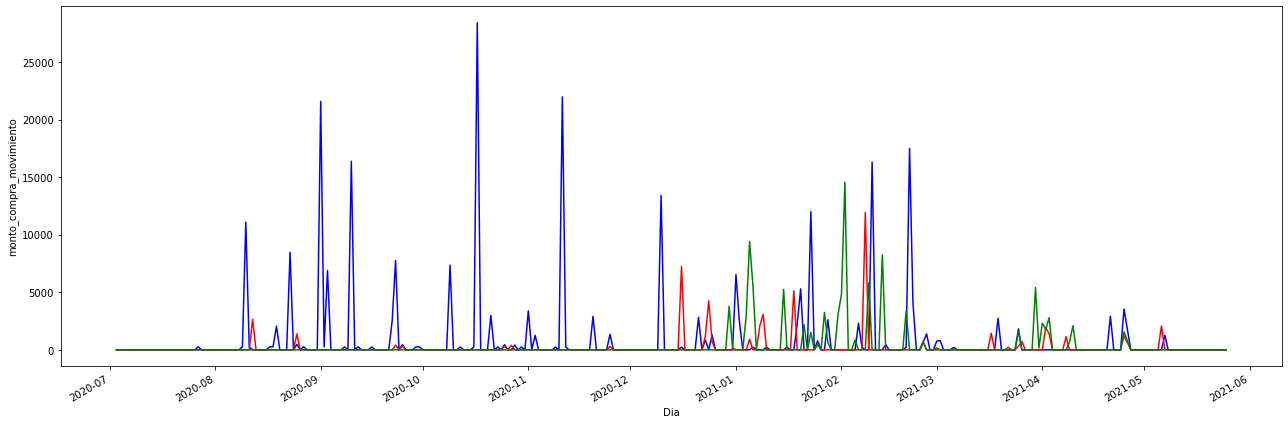

In [30]:
fig = plt.figure(figsize=(18, 6))

ax = plt.subplot(1, 1, 1)
dfs['000ef071e95351afc1149fa1afe4862a079'].plot(color='blue')
dfs['000f0b73ebfa002a79a0642b82e87919904'].plot(color='red')
dfs['000edf1f0ef2ba6fb1c639c4fb82133b037'].plot(color='green')
ax.set_xlabel('Dia')
ax.set_ylabel('monto_compra_movimiento')

plt.tight_layout()
plt.show()

#### Time Series Kmeans

In [31]:
sample_days = 200
first_day = 100

Usamos solo un rango de 200 dias para calcular los clusters, para hacer mas liviano al modelo. Para los dnis usamos todos porque necesitamos un numero de cluster para cada dni.

In [32]:
X_train = StandardScaler().fit_transform(dfs.iloc[first_day:first_day+sample_days,:])

In [33]:
X_train = StandardScaler().fit_transform(dfs)

In [34]:
X_train = X_train.T

In [35]:
X_train.shape

(844, 319)

#### Calculo de inercia y silhouet optimas

Usando la metrica euclideana el modelo corre mas rapido, asi que vamos a usarla para calcular el numero optimo de clusters usando la incercia y el coeficiente de silueta

In [36]:
inertia = []
silhouet = []
for n in range(2, 15):
    km = TimeSeriesKMeans(n_clusters=n, n_jobs=4, random_state=42, 
                          max_iter=1000, metric='euclidean').fit(X_train) 
                          #  “softdtw” , 'euclidean'
    inertia.append(km.inertia_)
    silhouet.append(silhouette_score(X_train, km.labels_,  metric='euclidean'))

Text(0.5, 1.0, 'Silhouet score versus number of clusters')

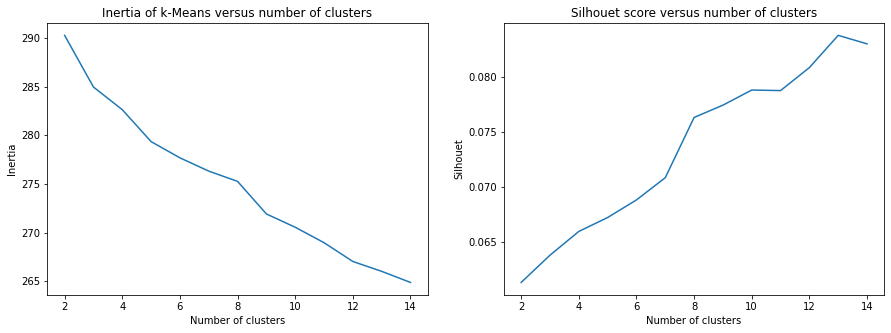

In [37]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(2, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of k-Means versus number of clusters")

plt.subplot(1,2,2)
plt.plot(np.arange(2, 15), silhouet)
plt.xlabel('Number of clusters')
plt.ylabel("Silhouet")
plt.title("Silhouet score versus number of clusters")

Euclidean k-means
491.505 --> 286.917 --> 280.316 --> 279.125 --> 278.508 --> 278.218 --> 278.035 --> 277.924 --> 277.833 --> 277.751 --> 277.565 --> 277.390 --> 277.232 --> 277.091 --> 277.040 --> 276.993 --> 276.929 --> 276.907 --> 276.903 --> 276.894 --> 276.891 --> 276.891 --> 
DBA k-means


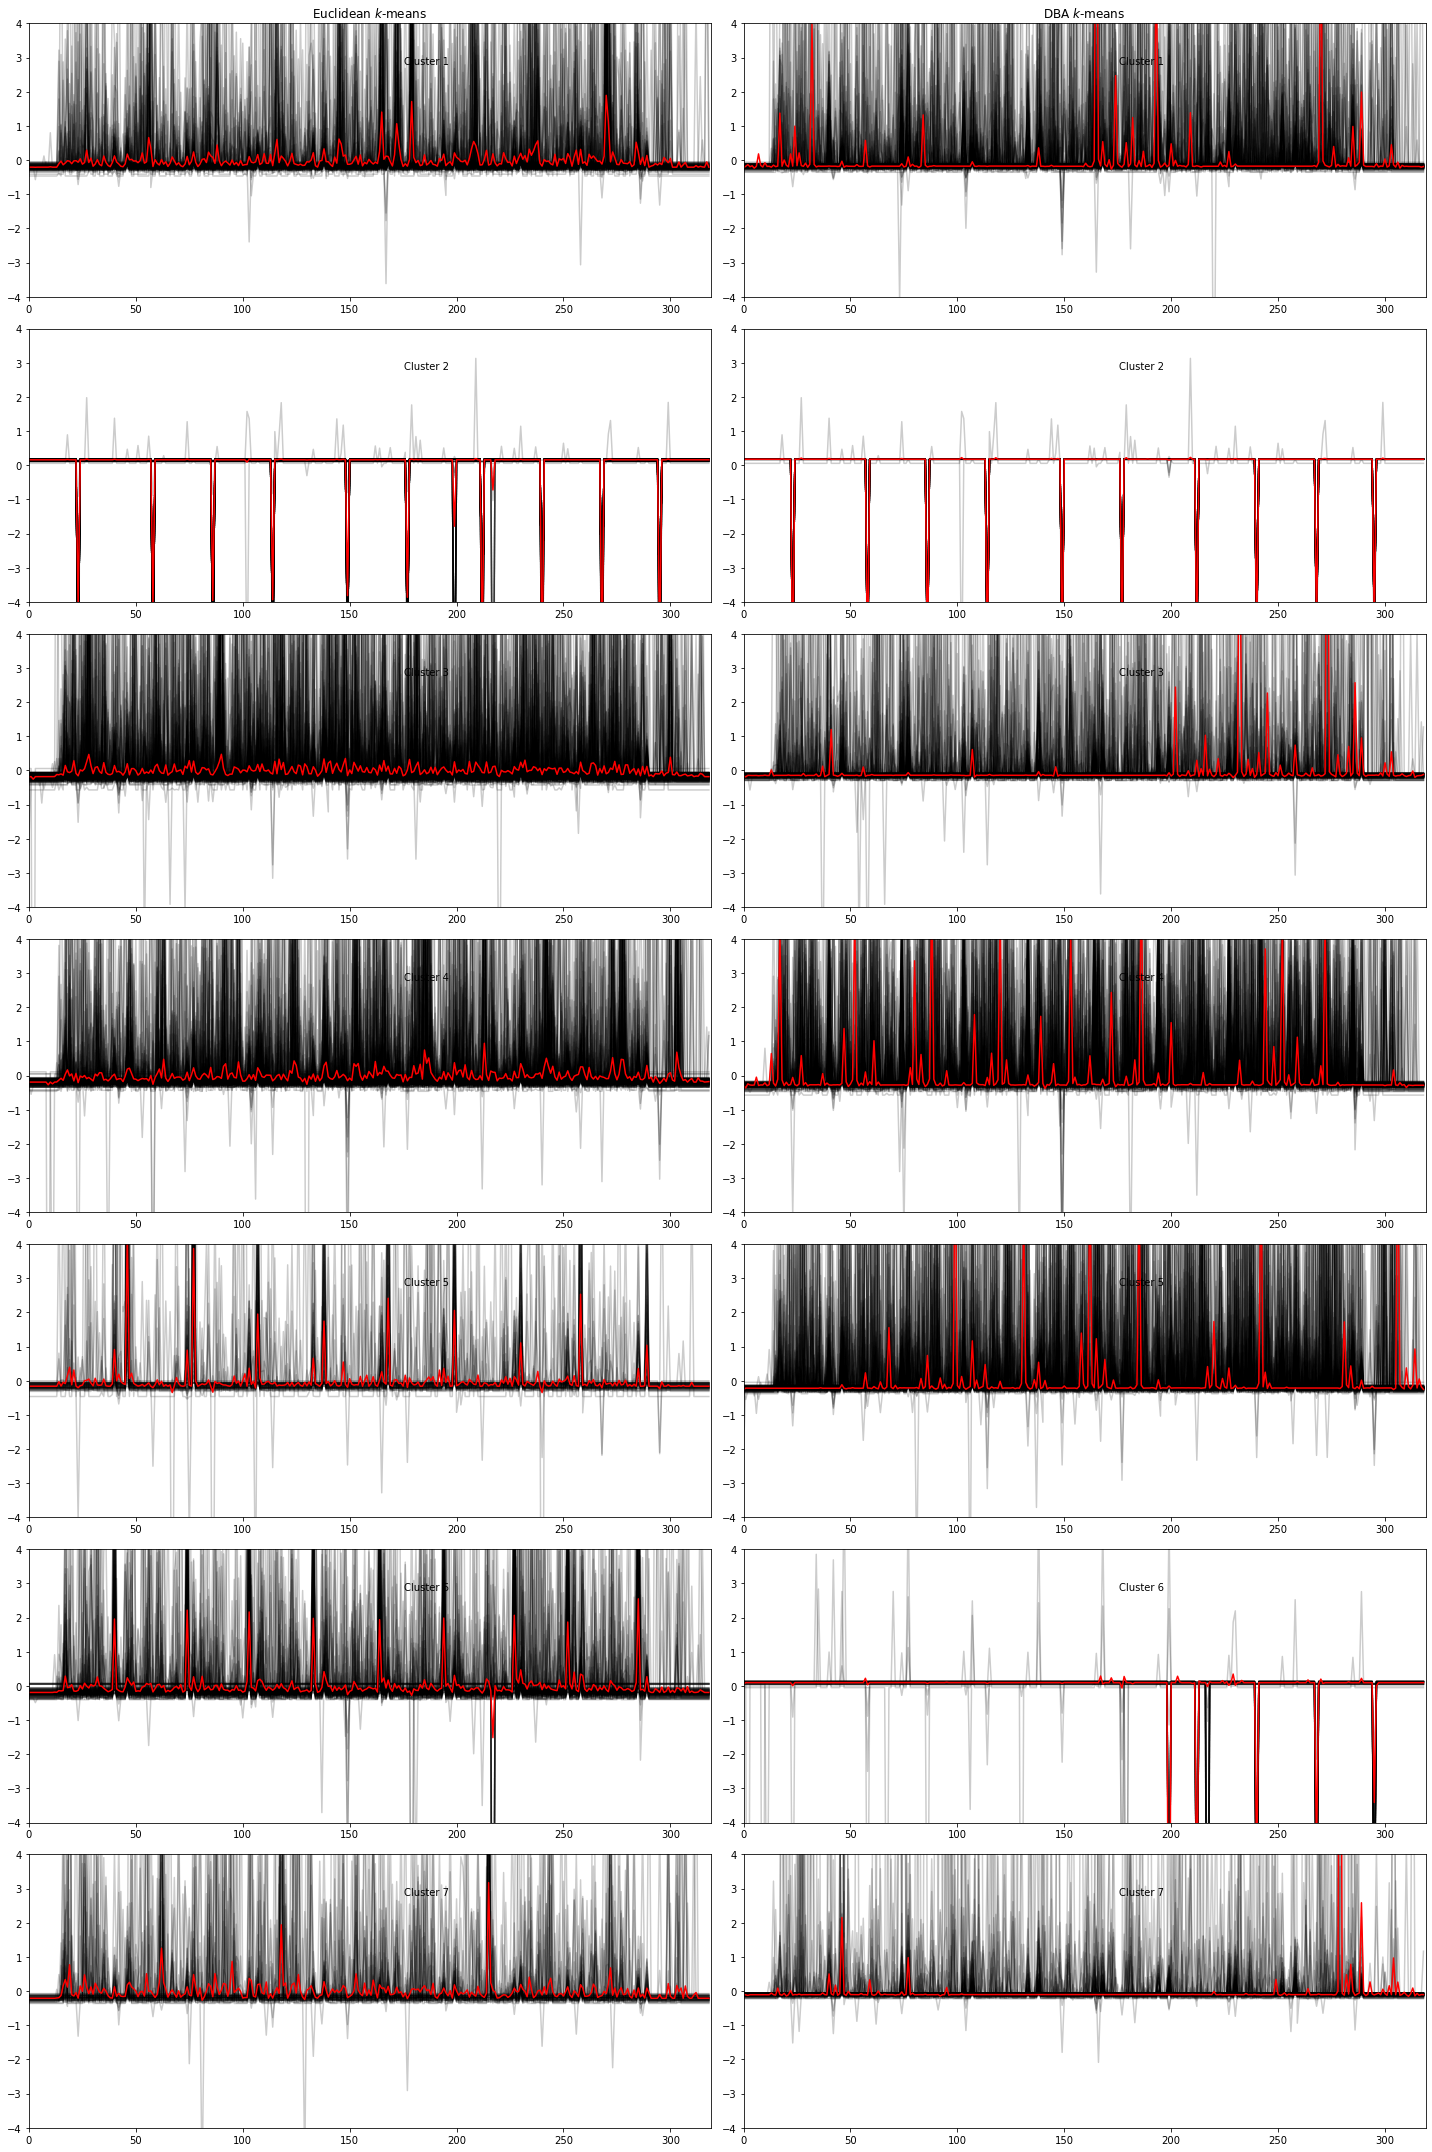

In [38]:
num_clust = 7
num_models = 2
sz = X_train.shape[1]
seed = 0

# Euclidean k-means
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=num_clust, verbose=True, random_state=seed)
y_pred_euc = km.fit_predict(X_train)

fig = plt.figure(figsize=(20,30))

for yi in range(num_clust):
    plt.subplot(num_clust, num_models, yi*num_models+1)
    for xx in X_train[y_pred_euc == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("Euclidean $k$-means")

#X_train = TimeSeriesScalerMeanVariance().fit_transform(dfs.iloc[first_day:first_day+sample_days,0:sample_dnis])

# DBA-k-means
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=num_clust,
                          n_init=2,
                          metric="dtw",
                          max_iter_barycenter=10,
                          random_state=seed)
y_pred_dtw = dba_km.fit_predict(X_train)

for yi in range(num_clust):
    plt.subplot(num_clust, num_models, yi*num_models+2)
    for xx in X_train[y_pred_dtw == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 0:
        plt.title("DBA $k$-means")

plt.tight_layout()
plt.show()

#### Observaciones sobre los clusters encontrados por los tres modelos. 

- Para los tres modelos hay al menos 1 cluster que concentra los dnis con montos negativos altos

In [39]:
X_train.shape

(844, 319)

Creamos un nuevo dataframe a partir de los dnis y sus respectivos clusters

In [40]:
dfts_km = pd.DataFrame({'dni_cliente':dfs.T.index.values, 'clust_ts_kmeuc':y_pred_euc, 'clust_ts_kmdtw':y_pred_dtw})

Balance de clases para cada clusterizador. Vemos que dtw tiene un mejor balance. 

In [41]:
dfts_km['clust_ts_kmeuc'].value_counts()

2    240
3    190
5    111
0    108
1     82
4     59
6     54
Name: clust_ts_kmeuc, dtype: int64

In [42]:
dfts_km['clust_ts_kmdtw'].value_counts()

4    179
3    152
0    148
2    147
6    120
1     56
5     42
Name: clust_ts_kmdtw, dtype: int64

In [43]:
df_tsclust = df_escalado.merge(dfts_km, left_on='dni_titular_movimiento', right_on='dni_cliente')[['clust_ts_kmeuc', 'clust_ts_kmdtw']]

In [44]:
df_tsclust['clust_ts_kmeuc'].values

array([1, 1, 1, ..., 6, 6, 6])

Para kmeans con distancia euclideana el silhouette_score promedio es : 0.07020948240508663
Para kmeans con distancia dtw el silhouette_score promedio es : 0.06522029355096295


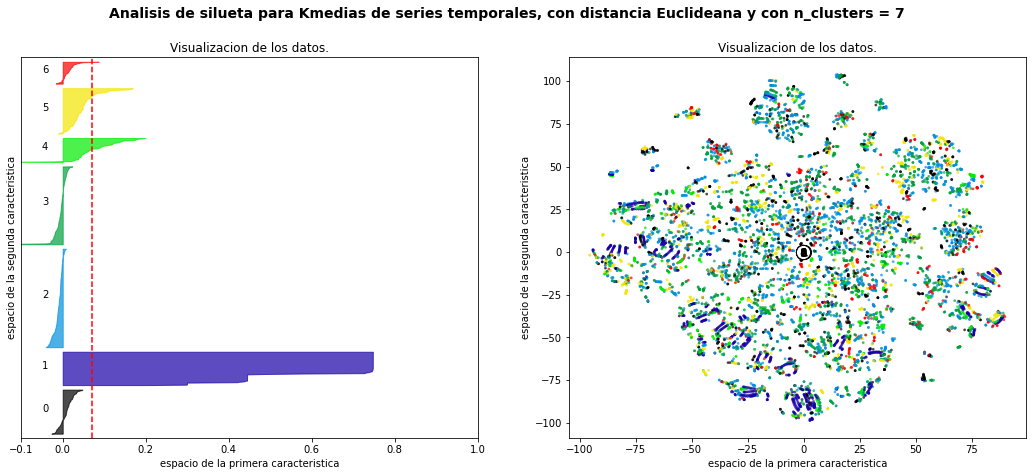

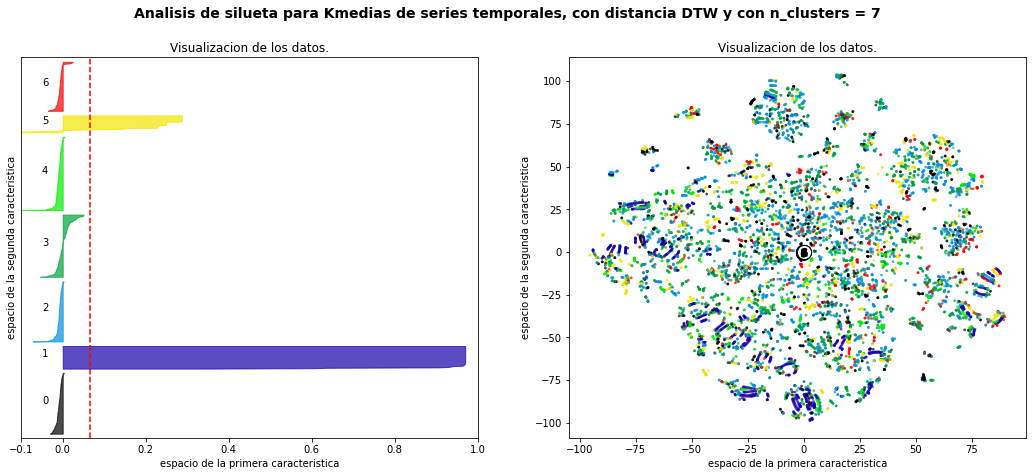

In [45]:
sse ={}

X = X_train
for n_model in range(num_models):
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (num_clust + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    if n_model == 0:
        clusterer = km
        cluster_labels = y_pred_euc
    else:
        clusterer = dba_km
        cluster_labels = y_pred_dtw
        
    sse[n_model] = clusterer.inertia_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    if n_model == 0:
        print("Para kmeans con distancia euclideana "
              "el silhouette_score promedio es :", silhouette_avg)
    else:
        print("Para kmeans con distancia dtw "
              "el silhouette_score promedio es :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(num_clust):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / num_clust)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Visualizacion de los datos.")
    ax1.set_xlabel("espacio de la primera caracteristica")
    ax1.set_ylabel("espacio de la segunda caracteristica")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    # 2nd Plot showing the actual clusters formed
    if n_model == 0:
        transact_labels = df_tsclust['clust_ts_kmeuc'].values
    else:
        clusterer = dba_km
        cluster_labels = df_tsclust['clust_ts_kmdtw'].values
        
    colors = cm.nipy_spectral(transact_labels.astype(float) / num_clust)
    ax2.scatter(X_tsne_all[:, 0], X_tsne_all[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("Visualizacion de los datos.")
    ax2.set_xlabel("espacio de la primera caracteristica")
    ax2.set_ylabel("espacio de la segunda caracteristica")
    
    if n_model == 0:
        plt.suptitle(("Analisis de silueta para Kmedias de series temporales, con distancia Euclideana y "
                  "con n_clusters = %d" % num_clust),
                 fontsize=14, fontweight='bold')
    else:
        plt.suptitle(("Analisis de silueta para Kmedias de series temporales, con distancia DTW y "
                  "con n_clusters = %d" % num_clust),
                 fontsize=14, fontweight='bold')
    
    #plt.savefig("kmeans_%d" % n_clusters, dpi=300)